# 적대적 생성 신경망(Generative Adversarial Networks, GAN)

- 2014년, Ian Goodfellow 소개

- VAE와는 다른 방법으로 이미지 잠재 공간을 학습

- 직관적으로 이해하는 방법

  - 가짜 피카소 그림을 그리는 위조범과 이를 판별하는 판매상의 관계

  - 위조품과 진짜 그림을 섞어서 판매상에게 보여주며  
    그림이 진짜인지 가짜인지 판매상은 판별하고 이를 위조범에게 피드백

  - 처음에는 형편없는 그림을 그리다가 점점 피카소의 스타일을 모방하게 되고  
    판매상은 위조품을 구분하는데 점점 더 전문가가 되어감

- GAN의 네트워크

  - 생성자 네트워크(generator network)

    - 랜덤 벡터(잠재 공간의 무작위한 포인트)를 입력으로 받아 이를 합성된 이미지로 디코딩

  - 판별자 네트워크(discriminator netowrk)

    - 이미지(실제 또는 가짜 이미지)를 입력으로 받아 훈련 세트에서 온 이미지인지 생성자가 만든 이미지인지 판별

- GAN은 최적화의 최솟값이 고정되어 있지 않음

  - 보통의 경사하강법은 고정된 손실공간
  *에서 언덕을 내려오는 훈련 방법이지만  
    GAN은 매 단계가 조금씩 전체 공간을 바꾸기 때문에 최적화 과정이 최솟값을 찾는 것이 어려움

  - 두 힘간의 평형점을 찾는 시스템

  - 따라서, 학습과정이 매우 어려움  
    즉, 적절한 파라미터를 찾고 조정해야함
  
  <img src="https://paperswithcode.com/media/methods/gan.jpeg">

https://pseudo-lab.github.io/Tutorial-Book/chapters/GAN/Ch1-Introduction.html

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DCGAN

MLP을 사용한 GAN vs. DCGAN<br>

DCGAN - Deep Convolutional generative adversarial network <br>
https://github.com/effectivemadness/celebA_gan
CelebA 데이터 다운로드

In [2]:
!pwd

/content


In [3]:
!mkdir celeba_gan
!wget "https://drive.google.com/uc?id=1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9&confirm=t%22" -O celeba_gan/data.zip
!unzip -qq celeba_gan/data.zip -d celeba_gan

--2023-01-20 00:50:28--  https://drive.google.com/uc?id=1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9&confirm=t%22
Resolving drive.google.com (drive.google.com)... 74.125.28.101, 74.125.28.102, 74.125.28.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.28.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6ko2te7u60thpdgdldalujofar9dsl50/1674175800000/10613826186492816817/*/1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9?uuid=45611b8e-322e-4bfd-a516-7ce55e57818f [following]
--2023-01-20 00:50:28--  https://doc-04-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6ko2te7u60thpdgdldalujofar9dsl50/1674175800000/10613826186492816817/*/1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9?uuid=45611b8e-322e-4bfd-a516-7ce55e57818f
Resolving doc-04-a4-docs.googleusercontent.com (doc-04-a4-docs.googleusercontent.com)... 172.253.123.132, 2607:f8b0:400c:c16::84
Connecting

In [4]:
#이미지 디렉토리에서 데이터셋 만들기
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    'celeba_gan',
    label_mode=None,
    image_size=(64,64),
    batch_size=32,
    smart_resize=True
)

Found 202599 files belonging to 1 classes.


In [7]:
#픽셀 값 범위 바꾸기
dataset = dataset.map(lambda x: x / 255.0)

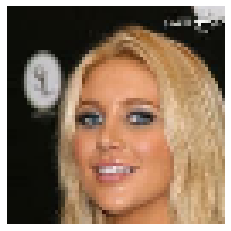

In [8]:
#첫번째 이미지 출력하기
import matplotlib.pyplot as plt
for x in dataset:
  plt.axis('off')
  plt.imshow((x.numpy() * 255).astype('int32')[0])
  break

GAN 판별자 네트워크

Conv2D(filters, kernel_size, strides, padding)
  - filters: 출력의 채널 크기를 지정합니다. (nums, width, height, filters)
  - kernel_size: 합성곱 행렬의 크기를 지정합니다.
  - stides: 합성곱 행렬의 1 Step Size를 지정합니다.
  - padding: same → Input의 각 변에 padding을 추가합니다. 이 때, 입력의 width, height와 출력의 width, height가 같아집니다.

https://zzsza.github.io/data/2018/02/23/introduction-convolution/

Output Size = ((W - F + 2P) / S)+ 1 <br>
W: input_volume_size<br>
F: kernel_size<br>
P: padding_size<br>
S: strides<br>

In [10]:
from tensorflow.keras import layers

discriminator = keras.Sequential([
    keras.Input(shape=(64,64,3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
],name = 'discriminator')

In [11]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

GAN 생성자 네트워크

In [13]:
latent_dim = 128

generator = keras.Sequential([
    keras.Input(shape=(latent_dim,)),
    layers.Dense(8*8*128),
    layers.Reshape((8, 8, 128)),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(3, kernel_size=5, padding='same', activation='sigmoid'),
], name = 'generator')

In [14]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

# GAN 모델

- Step One

batch_size 입력으로 받은 real_images의 개수를 저장합니다.

random_latent_vectors batch_size 만큼 generator에 입력할 latent_vector를 생성합니다.
ex) batch_size=512, latent_vector=128 일 때, (512, 128) 크기의 random vector 생성

generated_images generator에 latent_vector를 입력하여 가짜 이미지를 생성합니다.

combined_images 실제 이미지와 가짜 이미지를 연결하여 하나의 텐서로 만듭니다.

labels 실제 이미지와 가짜 이미지는 모두 batch_size만큼 있습니다. 실제 이미지에는 1을, 가짜 이미지에는 0을 할당 할 텐서를 만듭니다.

labels += 0.05 * tf.random.uniform(tf.shape(labels))
labels는 현재 0 또는 1의 값을 가지고 있습니다. 여기에 0.05*Random(0~1) 값을 더하여 약간씩 다르게합니다. discriminator의 학습에만 사용되는데 Noise를 추가함으로 판별능력을 키울 수 있는 것 같습니다.
매우 중요한 트릭이라고하는데, 어떻게 성능을 향상 시킬 수 있는지 이유는 모르겠네요.

- Step Two

이전 GAN 의 가중치 갱신부와 같습니다.
다만, 이전에 선언한 labels 는 discriminator에 새로 선언한 정수만을 가지고 있는 misleading_labels 는 generator의 학습에 사용된다는 점이 다릅니다.

d_loss와 g_loss를 반환하고 함수를 종료합니다.

In [18]:
import tensorflow as tf

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__() #상속받은 keras.Model Class의 생성자를 실행
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    #property decorator로 메소드를 속성으로 선언
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

훈련 과정 동안에 이미지를 생성하기 위한 콜백

Callback 사용하기 - 커스텀 콜백 / 모델 학습 / 평가<br>
https://littlefoxdiary.tistory.com/87

keras.callbacks.Callback
콜백 객체를 생성

API에 명시된 함수를 작성하면, 지정한 학습과정에서 콜백함수를 호출 할 수 있으며 코드에서는 on_epoch_end 즉, epoch가 끝날 때 마다 함수를 실행

In [19]:
class GANMonitor(keras.callbacks.Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = keras.utils.array_to_img(generated_images[i])
      img.save(f'generated_img_{epoch:03d}_{i}.png')

In [ ]:
epochs = 30
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn = keras.losses.BinaryCrossentropy()
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/30
6332/6332 [==============================] - 1899s 297ms/step - d_loss: 0.5922 - g_loss: 1.3491
Epoch 2/30
6332/6332 [==============================] - 1878s 297ms/step - d_loss: 0.6766 - g_loss: 1.0465
Epoch 3/30
6332/6332 [==============================] - 1880s 297ms/step - d_loss: 0.6777 - g_loss: 1.0084
Epoch 4/30
6332/6332 [==============================] - 1879s 297ms/step - d_loss: 0.6752 - g_loss: 1.0204
Epoch 5/30
6332/6332 [==============================] - 1882s 297ms/step - d_loss: 0.6645 - g_loss: 1.0384
Epoch 6/30
6332/6332 [==============================] - 1880s 297ms/step - d_loss: 0.6440 - g_loss: 1.0785
Epoch 7/30
6332/6332 [==============================] - 1881s 297ms/step - d_loss: 0.6403 - g_loss: 1.0374
Epoch 8/30
6332/6332 [==============================] - 1883s 297ms/step - d_loss: 0.6784 - g_loss: 0.9287
Epoch 9/30
3838/6332 [=================>............] - ETA: 12:19 - d_loss: 0.6819 - g_loss: 0.8984

https://www.tensorflow.org/tutorials/generative/dcgan